# Titanic Data
### *Andrea Cano*
***

## Introduction

The following graphs and matrices show the collected data based on the Tragedy of the Titanic. The data will be preprocessed and explored to provide physical representations of the information provided. 
Then the data collected will be engaged in multiple machine learning algorithms that will predict survival based on said features. 

***

## Loading Data

The first step is importing the necessary libraries and to collect the respective csv file containing the raw data.
In my example I have multiple dataframes to separate the categorical and numeric features along with a dataframe containing the features being actively used in this notebook. 

Note: 
    I did not include columns such as: "PassengerId", "Name", "Parch", "Ticket", and "Cabin".

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
csv = pd.read_csv("C:/Users/Andrea/Downloads/train.csv")


#creating non-null
dat = pd.DataFrame(csv)

datCat = pd.DataFrame(dat[["Sex","Pclass", "Survived", "Embarked"]])
datNum = pd.DataFrame(dat[["Age","Fare"]])

datUse = pd.DataFrame(dat[["Age","Fare","Sex","Pclass", "Survived", "Embarked"]])

numDatArr = ["Age","Fare"]
catDatArr = ["Sex","Pclass", "Survived", "Embarked"]


***
## Preprocessing

* In this section any NA's that are hiding within the data will be converted and fixed so that they are no longer considered NA's and will be easier to work with. To do this, two pipelines are needed in order to convert the numeric and categorical separately. 

* The numerical pipeline uses the median of the said columns data and also scales the data to replace NA's and create consistent data. 

* The categorical pipeline, however, uses mode or the most frequent option that appears in the columns to replace the NA's.

* In the end a feature union is required to put both the resulting pipelines together, concatenating the data as a single numpy matrix.

In [24]:
#create a class to select colummns from a dataframe

class DataSelect(BaseEstimator,TransformerMixin):
    def __init__(self, colNames):
        self.colNames = colNames
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return  X[self.colNames]


#Getting rid of NA's for numerical data
pipeNumeric = Pipeline([
 ("select_cols", DataSelect(numDatArr)),
 ("remove_nas", Imputer(strategy="median")),
 ("z-scaling", StandardScaler())

 ])
pipNum = pipeNumeric.fit_transform(datNum)

#Need to deal with strings in categorical before putting in piepline so use get_dummies

class DumCat(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Adding dummies when needed"""
    def fit(self, X,y=None):
        self.dummyDat = pd.get_dummies(X) #Creating dataFrame to run the function
        return self
    def transform(self,X):
        return self.dummyDat #return the dummyDat that has the new columns

datTest = pd.DataFrame(dat[["Embarked"]])

DumCat().fit_transform(datTest) 
#to access, need to Class.fit_transform(dataWantChanged)


#Getting rid of NA's for categorical data
pipeCategory = Pipeline([
 ("select_cols", DataSelect(catDatArr)),
 ("get_dummies", DumCat()),
 ("remove_nas", Imputer(strategy="most_frequent")),
 ])
pipCat = pipeCategory.fit_transform(datCat)


#Now that the data is processed, need to join the Numerical and Categorical 

full_pipeline = FeatureUnion(transformer_list=[
         ('cat_data',pipeCategory),
        ('num_data',pipeNumeric)
        ])
united = full_pipeline.fit_transform(datUse)
united


array([[ 3.        ,  0.        ,  0.        , ...,  1.        ,
        -0.56573646, -0.50244517],
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.66386103,  0.78684529],
       [ 3.        ,  1.        ,  1.        , ...,  1.        ,
        -0.25833709, -0.48885426],
       ...,
       [ 3.        ,  0.        ,  1.        , ...,  1.        ,
        -0.1046374 , -0.17626324],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
        -0.25833709, -0.04438104],
       [ 3.        ,  0.        ,  0.        , ...,  0.        ,
         0.20276197, -0.49237783]])

***
## Data Exploration

Now we are able to explore the data! 

* Starting with a simple countplot, we see the general ratio of survivors of the Titanic wreck. In this plot 0 represents those who did not survive while 1 represents those who did.

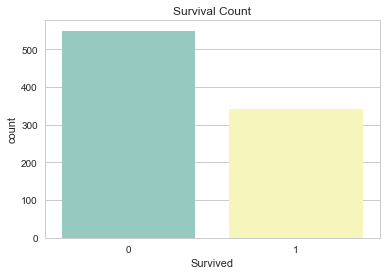

In [5]:
sns.set(style="whitegrid")
sns.countplot(x="Survived",data =dat, palette="Set3")
plt.title("Survival Count");

* This barplot shows the Survival probability based on Age and Sex; where again, Survived is 1 and 0 is where they did not. There are not that large of differences, tough it seems that men over 25 most likely did not make it.

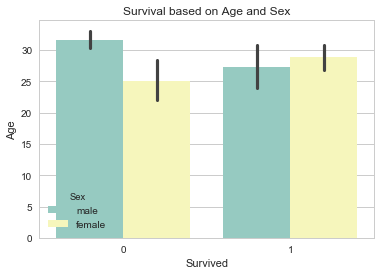

In [6]:
sns.barplot(x= "Survived", y="Age", hue ="Sex",data = dat, palette="Set3")
plt.title("Survival based on Age and Sex");

* This plot shows the passengers classes and sex. Each class had more males than females where 3rd class was extremely male dominated. I am assuming this is because of the workers aboard the Titanic were mostly male.

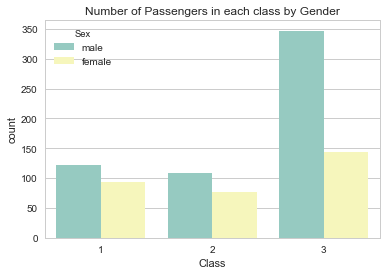

In [7]:
sns.countplot("Pclass", data=dat, hue="Sex",palette="Set3")
plt.title("Number of Passengers in each class by Gender")
plt.xlabel("Class");

* Lastly, here is a violin plot that represents the Age and Gender of the Passengers. The colors then represent who lived and who did not. It is surprising to see that more females younger than 20 seemed to have not survived especially since more young men were able to survive since woman and children were to be boarded in the lifeboats first. This explains why the female violin is wider.

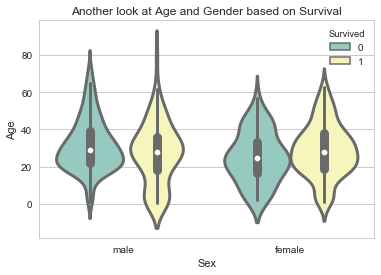

In [8]:
sns.violinplot(x="Sex", y = "Age", hue ="Survived", data=dat, inner="box", palette="Set3", cut=2, linewidth=3)
plt.title("Another look at Age and Gender based on Survival");

***
## Machine Learning Algorithms

* Splitting the training data into test data. Using the fitted and transformed data from the pipelines and splitting them based on the data to be used (x) and the target (y).

In [9]:
from sklearn.model_selection import train_test_split

x = united[:,[2,3,7]] #sex(2,3) and age(7)
y = united[:,1] #survived
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5)

### * Decision Tree

* The first algorithm I am testing is the decision tree. Basing off of Sex and Age, the output shows how well these features affect the survival rate. The score produced shows a 76%+ accuracy in prediction.

In [19]:
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_test)
score = decisiontree.score(x_test,y_test)
score

0.7668161434977578

* Here is a confusion matrix to show the number of conditional positives and negatives.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[229,  42],
       [ 62, 113]], dtype=int64)

### * Logistic Regression

* Next algorithm used is logistic regression. Again using Sex and Age, the output shows that with this algorithm there is a 78%+ accuracy to predict survival with these features. Logistic Regression has a higher accuracy because it works best with one or more independent variables to predict something with only two outcomes which makes survival a great target. 

In [21]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_train)
log_scores = log_reg.score(x_test,y_test)
log_scores

0.7802690582959642

***
### Using other Features

* In this example Pclass and Sex will be the selected features to predict survival using the same  algorithms above.

In [25]:
x = united[:,[0,2,3]] #pclass(0) and sex(2,3)
y = united[:,1] #survived
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5)

### * Decision Tree
* The score from the Decision tree with these features is more successful by ~3% than the score from using the combination of Sex and Age.

In [26]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_test)
score = decisiontree.score(x_test,y_test)
score

0.7914798206278026

* Even the confusion matrix shows the distinct difference between the errors found with these features than the previous ones.

In [27]:
confusion_matrix(y_test,y_pred)

array([[275,   4],
       [ 89,  78]], dtype=int64)

### * Logistic Regression 
* The score from using logistic regression with these features is only slightly better than the other features with ~1% of a difference. Of course it is still an improvement from the others.

In [28]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_train)
log_scores = log_reg.score(x_test,y_test)
log_scores

0.8004484304932735

***
## Conclusion

* From the algorithms conducted, sex and age and pclass and sex are both pretty fair predictors of survival on the Titanic. Although sex and age has a smaller score than pclass and sex, the algorithms differed more based on which was used. Logistic Regression worked best for both instances, probably due to the fact that logistic is based on predicting two-outcome results. However, the decision tree competed pretty well when it came to using the features Pclass and Sex, this seems more likely because both Pclass and Sex categorical so it seems easier to categorize and find similarities. 